In [6]:
import numpy as np
import matplotlib.pyplot as plt

In [7]:
from IPython.display import HTML
HTML("<style>div.output_area pre { font-family: 'Courier New', monospace; }</style>")

In [8]:
from apad_env import APADEnv, PIECES

Coordinate system: Top left is 0,0. Zeroeth row, second column would be 0,2.

In [9]:
def test_environment():
    env = APADEnv()
    
    # Test 1: Grid initialization
    assert env.grid.shape == (7, 7)
    assert np.sum(env.grid == -1) == 6  # Invalid positions
    assert np.sum(env.remaining_pieces) == 8  # All pieces available
    
    # Test 2: Piece coordinate generation
    coords_k = env._get_piece_coords(0, 0, 0)  # K piece, no flip, no rotation
    expected_k = [(0,0), (1,0), (2,0), (3,0), (2,1)]
    assert coords_k == expected_k
    
    # Test 3: Rotation
    coords_k_rot = env._get_piece_coords(0, 0, 1)  # K piece rotated 90°
    assert len(coords_k_rot) == 5
    
    # Test 4: Valid placement
    valid = env._is_valid_placement(0, 0, 0, 14)  # Position (2,0) on grid
    assert isinstance(valid, bool)
    
    # Test 5: Invalid placement (out of bounds)
    valid = env._is_valid_placement(0, 0, 0, 6)  # Top-right corner invalid
    assert valid == False
    
    # Test 6: Piece placement
    if env._is_valid_placement(0, 0, 0, 14):
       env._place_piece(0, 0, 0, 14)
       assert not env.remaining_pieces[0]  # Piece marked as used
       assert np.sum(env.grid == 1) == 5   # 5 cells occupied by piece
    
    print("All tests passed")
    
test_environment()

All tests passed


In [10]:
def test_overlap_and_reset():
   env = APADEnv()
   
   # Find two valid positions for same piece type
   pos1 = 14  # Should be valid
   pos2 = 15  # Adjacent position
   
   # Place first piece
   if env._is_valid_placement(0, 0, 0, pos1):
       env._place_piece(0, 0, 0, pos1)
       
       # Try to place overlapping piece (should fail)
       overlap_valid = env._is_valid_placement(1, 0, 0, pos2)
       assert overlap_valid == False
       
       # Test reset
       obs, info = env.reset()
       assert np.sum(env.remaining_pieces) == 8  # All pieces available
       assert np.sum(env.grid > 0) == 0  # Only invalid cells marked
       
   print("Overlap and reset tests passed!")

test_overlap_and_reset()

Overlap and reset tests passed!


In [11]:
def test_random_trial():
    env = APADEnv()
    obs, _ = env.reset()
    
    while True:
       # Check if any valid moves exist
       valid_moves = []
       for action in range(env.action_space.n):
           piece_id = action // (2 * 4 * 43)
           if env.remaining_pieces[piece_id]:
               remaining = action % (2 * 4 * 43)
               chirality = remaining // (4 * 43)
               remaining = remaining % (4 * 43)
               rotation = remaining // 43
               position = remaining % 43
               if env._is_valid_placement(piece_id, chirality, rotation, position):
                   valid_moves.append(action)
       
       if not valid_moves:
           break
           
       action = np.random.choice(valid_moves)
       obs, reward, done, truncated, _ = env.step(action)
       if done:
           break
    
    #print(f"Pieces remaining: {sum(env.remaining_pieces)}")
    return env

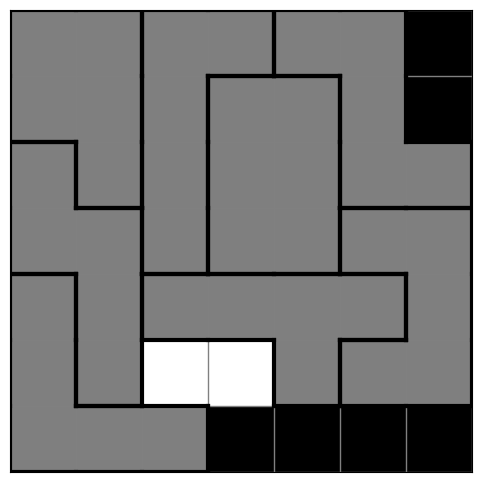

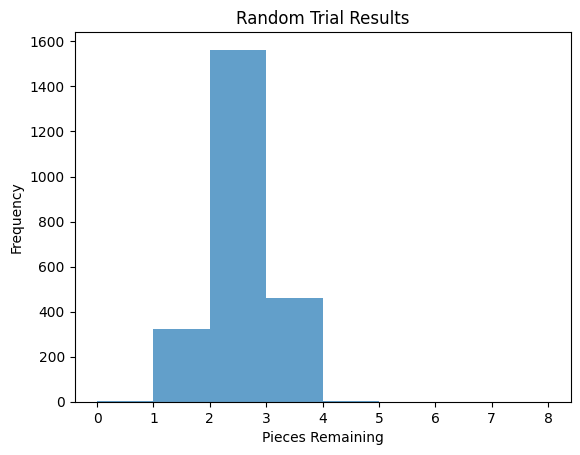

Trials: 2348, Success rate: 0.04%


<Figure size 640x480 with 0 Axes>

In [12]:
i = 0
remaining_pieces = []
while True:
    i += 1
    env = test_random_trial()
    remaining_pieces.append(np.sum(env.remaining_pieces))
    if np.sum(env.remaining_pieces) == 0:
        env.visualize()
        break

plt.hist(remaining_pieces, bins=range(9), alpha=0.7)
plt.xlabel('Pieces Remaining')
plt.ylabel('Frequency')
plt.title('Random Trial Results')
plt.show()
plt.savefig('trial_results.png')

print(f"Trials: {i}, Success rate: {remaining_pieces.count(0)/i:.2%}")